In [1]:
!pip install kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Move the uploaded kaggle.json file to the required directory
!mkdir -p /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
import kaggle

dataset_name = 'modelnet40-princeton-3d-object-dataset'

kaggle.api.dataset_download_files('balraj98' + '/' + dataset_name, path='.', unzip=True)

In [5]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.2/690.2 kB 11.3 MB/s eta 0:00:00


In [6]:
import os
import glob
import trimesh
import numpy as np
from tensorflow import data as tf_data
import keras
from keras import layers
from matplotlib import pyplot as plt

keras.utils.set_random_seed(seed=42)

In [7]:
import tqdm
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
tf.random.set_seed(42)

In [ ]:
# visualize the triangular mesh files
mesh = trimesh.load('/content/ModelNet40/person/train/person_0001.off')
mesh.show()

In [ ]:
# visualize the triangular mesh files
mesh1 = trimesh.load('/content/ModelNet40/toilet/train/toilet_0005.off')
mesh1.show()

In [8]:
DATA_DIR = '/content/ModelNet40'

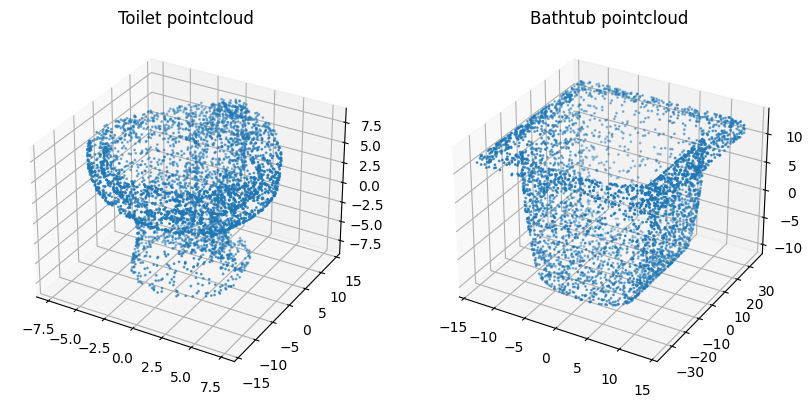

In [ ]:
mesh2 = trimesh.load(os.path.join(DATA_DIR, 'bathtub/train/bathtub_0010.off'))
points1 = mesh1.sample(4096)
points2 = mesh2.sample(4096)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points1[:, 0], points1[:, 1], points1[:, 2], s=1)
ax1.set_title('Toilet pointcloud')
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points2[:, 0], points2[:, 1], points2[:, 2], s=1)
ax2.set_title('Bathtub pointcloud')
#ax.set_axis_off()
plt.show()

In [ ]:
folders = os.listdir(DATA_DIR)
print(folders)

['curtain', 'dresser', 'sink', 'sofa', 'range_hood', 'plant', 'laptop', 'door', 'person', 'airplane', 'glass_box', 'stool', 'mantel', 'tent', 'wardrobe', 'table', 'vase', 'car', 'keyboard', 'bathtub', 'bottle', 'bench', 'stairs', 'night_stand', 'cup', 'tv_stand', 'cone', 'toilet', 'bed', 'flower_pot', 'bookshelf', 'monitor', 'guitar', 'radio', 'xbox', 'lamp', 'bowl', 'desk', 'chair', 'piano']


In [ ]:
for folder in folders:
    train_path = os.path.join(DATA_DIR, folder, 'train')
    test_path = os.path.join(DATA_DIR, folder, 'test')

    # Count the number of files in the "train" directory
    num_train_files = len(os.listdir(train_path))

    # Count the number of files in the "test" directory
    num_test_files = len(os.listdir(test_path))

    print(f"Class: {folder}, Train Files: {num_train_files}, Test Files: {num_test_files}")


Class: curtain, Train Files: 138, Test Files: 20
Class: dresser, Train Files: 200, Test Files: 86
Class: sink, Train Files: 128, Test Files: 20
Class: sofa, Train Files: 680, Test Files: 100
Class: range_hood, Train Files: 115, Test Files: 100
Class: plant, Train Files: 240, Test Files: 100
Class: laptop, Train Files: 149, Test Files: 20
Class: door, Train Files: 109, Test Files: 20
Class: person, Train Files: 88, Test Files: 20
Class: airplane, Train Files: 626, Test Files: 100
Class: glass_box, Train Files: 171, Test Files: 100
Class: stool, Train Files: 90, Test Files: 20
Class: mantel, Train Files: 284, Test Files: 100
Class: tent, Train Files: 163, Test Files: 20
Class: wardrobe, Train Files: 87, Test Files: 20
Class: table, Train Files: 392, Test Files: 100
Class: vase, Train Files: 475, Test Files: 100
Class: car, Train Files: 197, Test Files: 100
Class: keyboard, Train Files: 145, Test Files: 20
Class: bathtub, Train Files: 106, Test Files: 50
Class: bottle, Train Files: 335, T

In [9]:
# Parse all the off files with 2048 randomly sampled points to generate a training and testing dataset
def parse_dataset(num_points=1024):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = os.listdir(DATA_DIR)

    for i, folder in tqdm.tqdm(enumerate(folders)):
        print('processing class: {}'.format(folder))
        #store folder name with id that can be retrieved later
        class_map[i] = folder
        train_files = glob.glob(os.path.join(DATA_DIR, folder, 'train/*'))
        test_files = glob.glob(os.path.join(DATA_DIR, folder, 'test/*'))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return(
    np.array(train_points),
    np.array(train_labels),
    np.array(test_points),
    np.array(test_labels),
    class_map)

In [10]:
# declare model training parameters
NUM_POINTS = 1024
NUM_CLASSES = 40
BATCH_SIZE = 32

In [11]:
train_points, train_labels, test_points, test_labels, class_map = parse_dataset(NUM_POINTS)

0it [00:00, ?it/s]

processing class: tent


1it [00:38, 38.57s/it]

processing class: plant


2it [02:12, 71.08s/it]

processing class: bathtub


3it [02:23, 43.61s/it]

processing class: desk


4it [02:37, 31.87s/it]

processing class: mantel


5it [03:35, 41.39s/it]

processing class: xbox


6it [03:46, 31.02s/it]

processing class: night_stand


7it [03:57, 24.53s/it]

processing class: table


8it [04:19, 23.67s/it]

processing class: stool


9it [04:24, 17.81s/it]

processing class: tv_stand


10it [04:36, 16.05s/it]

processing class: wardrobe


11it [04:37, 11.62s/it]

processing class: sink


12it [04:49, 11.50s/it]

processing class: cone


13it [04:51,  8.67s/it]

processing class: glass_box


14it [04:53,  6.78s/it]

processing class: curtain


15it [05:59, 24.62s/it]

processing class: toilet


16it [06:38, 28.95s/it]

processing class: door


17it [06:41, 21.16s/it]

processing class: dresser


18it [07:05, 21.85s/it]

processing class: bottle


19it [07:30, 23.01s/it]

processing class: chair


20it [09:07, 45.00s/it]

processing class: radio


21it [09:21, 35.66s/it]

processing class: cup


22it [09:23, 25.55s/it]

processing class: bed


23it [10:17, 34.29s/it]

processing class: bookshelf


24it [11:32, 46.32s/it]

processing class: piano


25it [12:13, 44.90s/it]

processing class: bowl


26it [12:15, 31.95s/it]

processing class: guitar


27it [13:35, 46.29s/it]

processing class: laptop


28it [13:45, 35.36s/it]

processing class: keyboard


29it [14:19, 35.15s/it]

processing class: sofa


30it [15:40, 48.70s/it]

processing class: vase


31it [16:09, 42.89s/it]

processing class: person


32it [16:22, 33.96s/it]

processing class: airplane


33it [24:22, 167.65s/it]

processing class: flower_pot


34it [24:59, 128.56s/it]

processing class: stairs


35it [25:26, 98.14s/it] 

processing class: range_hood


36it [25:33, 70.78s/it]

processing class: monitor


37it [25:49, 54.32s/it]

processing class: bench


38it [25:56, 40.28s/it]

processing class: car


39it [28:49, 79.86s/it]

processing class: lamp


40it [28:56, 43.41s/it]


In [ ]:
np.save('3d_train_points1.npy', train_points)
np.save('3d_train_labels1.npy', train_labels)
np.save('3d_test_points1.npy', test_points)
np.save('3d_test_labels1.npy', test_labels)
with open('class_map_dict1.pkl', 'wb') as f:
    pickle.dump(class_map, f)


In [ ]:
train_points = np.load('/content/3d_train_points1.npy')
train_labels = np.load('/content/3d_train_labels1.npy')
test_points = np.load('/content/3d_test_points1.npy')
test_labels = np.load('/content/3d_test_labels1.npy')
with open('/content/class_map_dict1.pkl', 'rb') as f:
    class_map = pickle.load(f)

In [ ]:
len(train_points)

9843

In [ ]:
len(test_points)

2468

In [ ]:
print(len(train_labels))

9843


In [ ]:
print(len(test_labels))

2468


In [12]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

# generate tensors from the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
print(len(train_dataset))

308


In [ ]:
print(len(test_dataset))

78


In [13]:
# Convolution -> BatchNormalization -> ReLU block
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding='valid')(x)
    # The decay rate is initialized as 0.5 and gradually increased to 0.99 in the paper
    # Somehow, decay rate of 0.0 works best here
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation('relu')(x)

# Dense -> BatchNormalization -> ReLU block
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation('relu')(x)

In [14]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        # this step performs orthogonal transformation followed by Frobenius norm
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [15]:
def tnet(inputs, num_features):
    # Convolutional Block
    x = conv_bn(inputs, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    x = layers.GlobalMaxPooling1D()(x)

    # Fully Connected Block
    x = dense_bn(x, 512)
    x = dense_bn(x, 256)

    # Feature Transformation
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="Identity",
        bias_initializer="zeros",  # Use zeros as bias initializer
        activity_regularizer=None,  # Disable regularization for this layer
    )(x)

    # Reshape feature transform
    feat_T = layers.Reshape((num_features, num_features))(x)

    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [16]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

# T-net 1 with 3x3 output matrix
x = tnet(inputs, 3)

# Convolutional Blocks
x = conv_bn(x, 64)
x = conv_bn(x, 64)

# T-net 2 with 64x64 output matrix
x = tnet(x, 64)

# Convolutional Blocks
x = conv_bn(x, 64)
x = conv_bn(x, 128)
x = conv_bn(x, 1024)
x = layers.GlobalMaxPooling1D()(x)

# Fully Connected Blocks
x = dense_bn(x, 512)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 64)             256       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 64)             256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1024, 64)             0         ['batch_normalization[0

In [17]:
def step_decay(epoch):
    lrate = 0.001
    step = 20
    if epoch > 20:
        lrate = lrate/(2 * (epoch//step))
    return lrate

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0, beta_1=0.9, beta_2=0.999),
    metrics=["sparse_categorical_accuracy"],
)

checkpoints = keras.callbacks.ModelCheckpoint(filepath='pointnet_weights_v2.hdf5',\
                                              monitor='val_sparse_categorical_accuracy',\
                                              mode='max',\
                                              save_best_only=True,\
                                              save_weights_only=True)
lrate = keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [lrate, checkpoints]

model.fit(train_dataset, epochs=140, validation_data=test_dataset, callbacks=callbacks_list)

Epoch 1/140
308/308 [==============================] - 71s 161ms/step - loss: 3.5305 - sparse_categorical_accuracy: 0.1173 - val_loss: 12557784064.0000 - val_sparse_categorical_accuracy: 0.0669 - lr: 0.0010
Epoch 2/140
308/308 [==============================] - 50s 161ms/step - loss: 3.3419 - sparse_categorical_accuracy: 0.1573 - val_loss: 2482.1636 - val_sparse_categorical_accuracy: 0.0806 - lr: 0.0010
Epoch 3/140
308/308 [==============================] - 50s 163ms/step - loss: 3.2657 - sparse_categorical_accuracy: 0.1810 - val_loss: 13556763648.0000 - val_sparse_categorical_accuracy: 0.1426 - lr: 0.0010
Epoch 4/140
308/308 [==============================] - 49s 161ms/step - loss: 3.1605 - sparse_categorical_accuracy: 0.1855 - val_loss: 25732538368.0000 - val_sparse_categorical_accuracy: 0.1293 - lr: 0.0010
Epoch 5/140
308/308 [==============================] - 50s 162ms/step - loss: 3.1028 - sparse_categorical_accuracy: 0.2017 - val_loss: 1793208960.0000 - val_sparse_categorical_acc

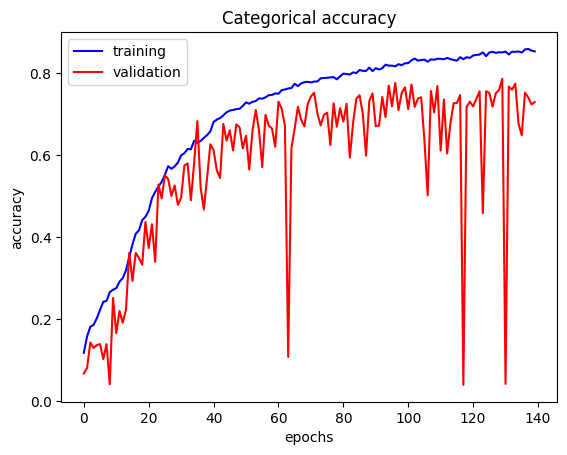

In [18]:
train_accuracy = model.history.history['sparse_categorical_accuracy']
val_accuracy = model.history.history['val_sparse_categorical_accuracy']
fig = plt.figure()
plt.plot(train_accuracy, color='blue', label='training')
plt.plot(val_accuracy, color='red', label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Categorical accuracy')
plt.legend(loc='best')
plt.show()

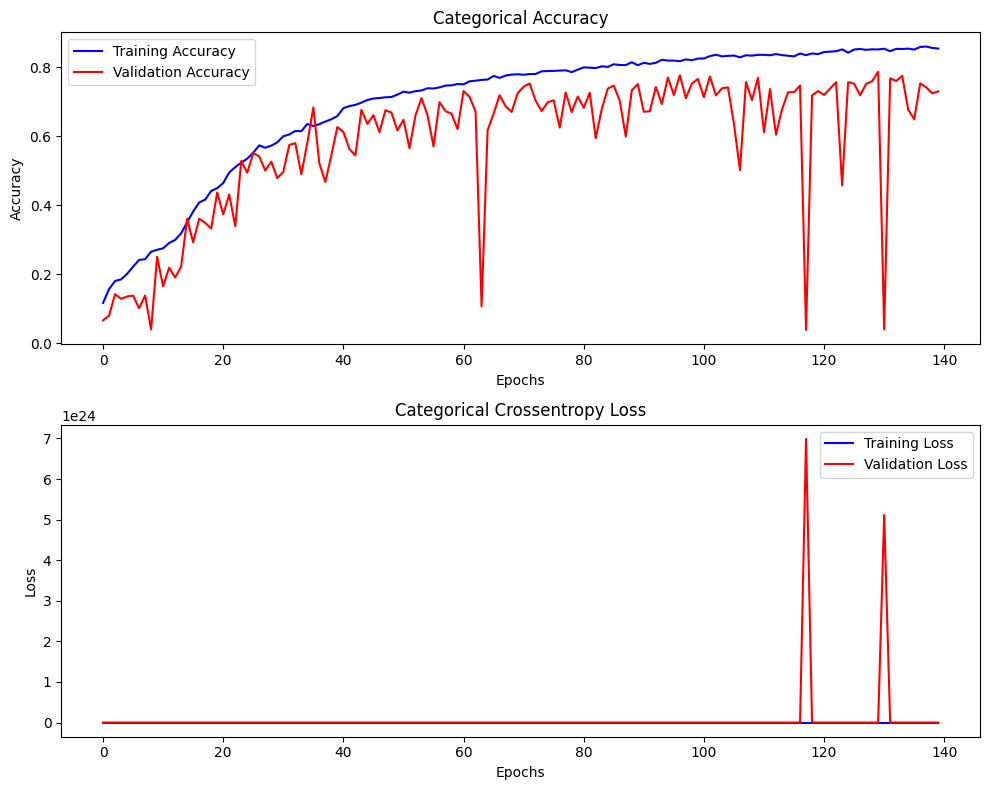

In [19]:
# Assuming you have trained your model using model.fit

# Access training and validation accuracy
train_accuracy = model.history.history['sparse_categorical_accuracy']
val_accuracy = model.history.history['val_sparse_categorical_accuracy']

# Access training and validation loss
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Plot accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(train_accuracy, color='blue', label='Training Accuracy')
ax1.plot(val_accuracy, color='red', label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Categorical Accuracy')
ax1.legend(loc='best')

# Plot loss
ax2.plot(train_loss, color='blue', label='Training Loss')
ax2.plot(val_loss, color='red', label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Categorical Crossentropy Loss')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()


In [20]:
# load best model weights
preds = model.predict(test_dataset)
preds = tf.math.argmax(preds, -1)
print('Validation accuracy: {}'.format(np.mean(test_labels == preds)))

78/78 [==============================] - 3s 36ms/step
Validation accuracy: 0.7301458670988655


In [21]:
preds = model.predict(test_dataset)
preds = tf.math.argmax(preds, -1)

# Convert TensorFlow tensor to NumPy array for comparison
preds_np = preds.numpy()

# Calculate accuracy
accuracy = np.mean(test_labels == preds_np)

# Print accuracy and loss
print('Validation Accuracy: {:.2%}'.format(accuracy))

# Evaluate the model on the test dataset to get the loss
loss = model.evaluate(test_dataset)[0]
print('Test Loss: {:.4f}'.format(loss))

78/78 [==============================] - 3s 36ms/step
Validation Accuracy: 73.01%
78/78 [==============================] - 3s 37ms/step - loss: 6378084.0000 - sparse_categorical_accuracy: 0.7301
Test Loss: 6378084.0000


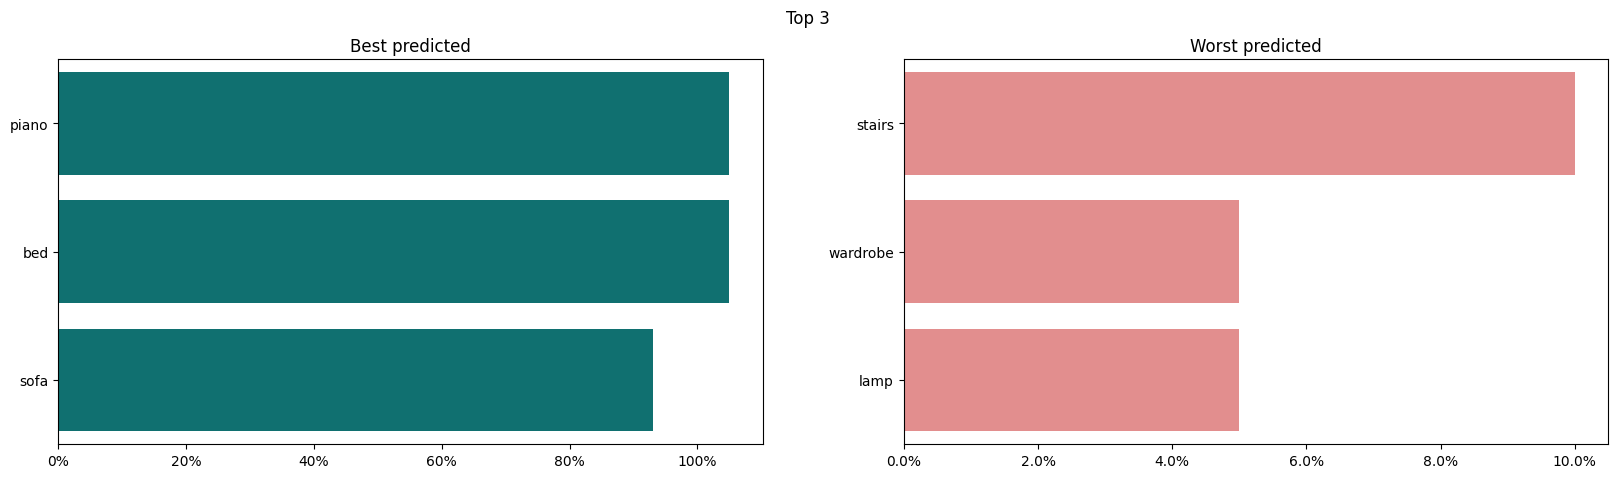

1/1 [==============================] - 1s 738ms/step


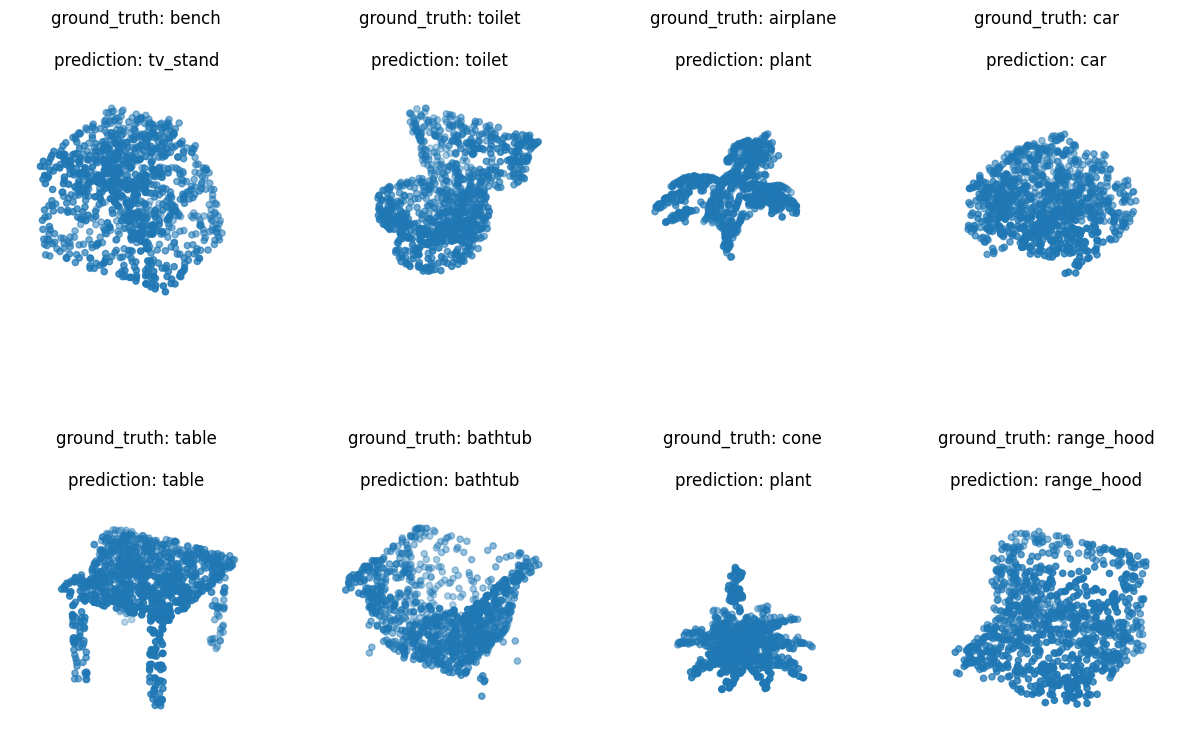

In [22]:
#shuffle test data
test_sample = tf.data.Dataset.from_tensor_slices((test_points, test_labels))
test_sample = test_sample.shuffle(len(test_points)).batch(BATCH_SIZE)
# plotting model predictions
data = test_sample.take(8)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "ground_truth: {:}\n\nprediction: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

1/1 [==============================] - 0s 20ms/step


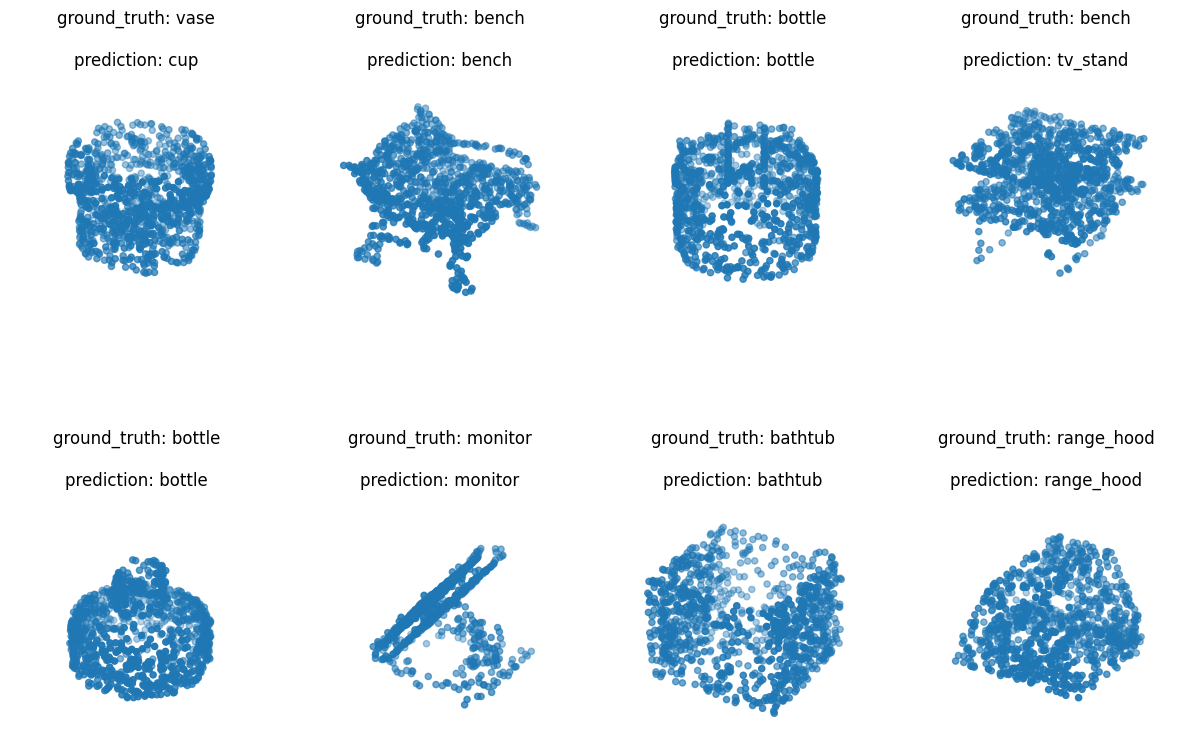

In [23]:
#shuffle test data
test_sample = tf.data.Dataset.from_tensor_slices((test_points, test_labels))
test_sample = test_sample.shuffle(len(test_points)).batch(BATCH_SIZE)
# plotting model predictions
data = test_sample.take(8)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "ground_truth: {:}\n\nprediction: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

1/1 [==============================] - 0s 20ms/step


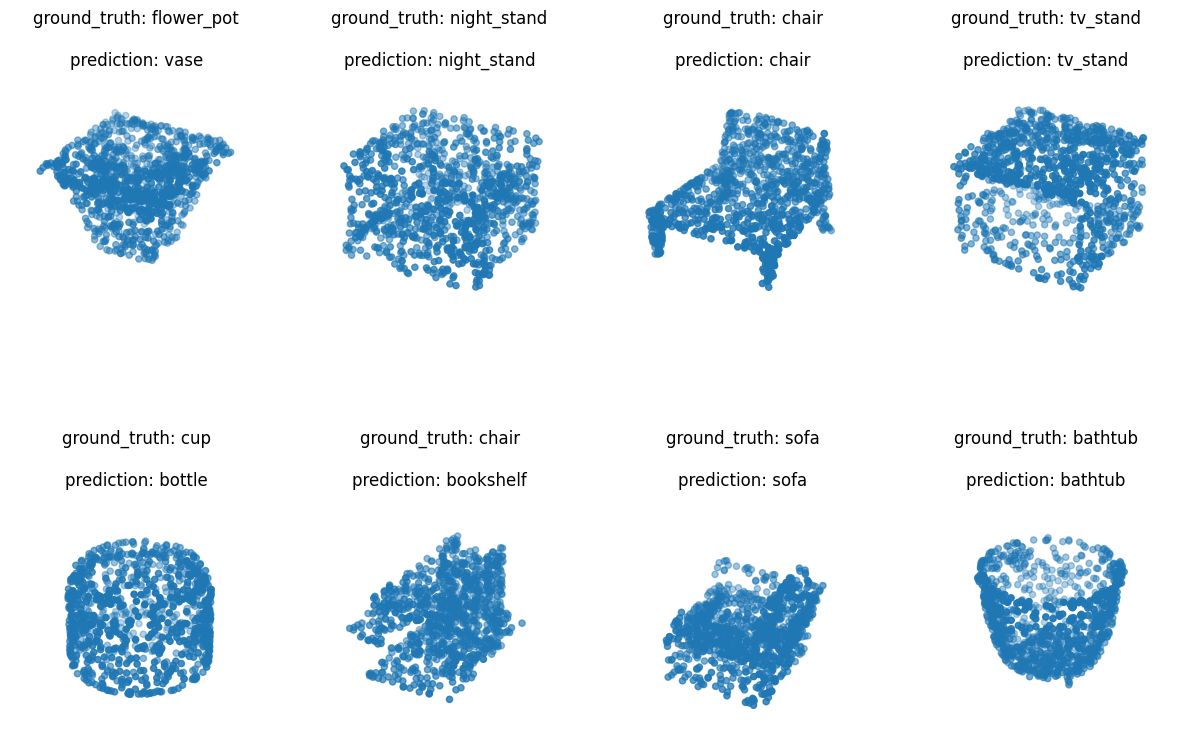

In [24]:
#shuffle test data
test_sample = tf.data.Dataset.from_tensor_slices((test_points, test_labels))
test_sample = test_sample.shuffle(len(test_points)).batch(BATCH_SIZE)
# plotting model predictions
data = test_sample.take(8)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "ground_truth: {:}\n\nprediction: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [25]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded the test dataset in the 'test_dataset' variable

# Evaluate the model on the test dataset
results = model.evaluate(test_dataset)

# Assuming your model outputs class probabilities (softmax activation), get the predictions
pred_probs = model.predict(test_dataset)

# Convert probabilities to class labels (assuming one-hot encoding)
predicted_labels = tf.argmax(pred_probs, axis=-1).numpy()

# Extract true labels from the test dataset
true_labels = []
for _, label in test_dataset:
    true_labels.extend(label.numpy())

# Assuming class_map contains the correct mapping of indices to class names
class_names = [class_map[i] for i in range(len(class_map))]

# Generate classification report
classification_rep = classification_report(true_labels, predicted_labels, labels=range(len(class_map)), target_names=class_names)

# Calculate additional metrics
acc_score = accuracy_score(true_labels, predicted_labels)
rec_score = recall_score(true_labels, predicted_labels, average='weighted')
prec_score = precision_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the classification report and additional metrics
print(classification_rep)
print("\nAccuracy Score:", acc_score)
print("Recall Score:", rec_score)
print("Precision Score:", prec_score)
print("F1 Score:", f1)

78/78 [==============================] - 3s 36ms/step
              precision    recall  f1-score   support

        tent       0.33      0.70      0.44        20
       plant       0.72      0.46      0.56       100
     bathtub       0.97      0.74      0.84        50
        desk       0.62      0.87      0.73        86
      mantel       0.89      0.87      0.88       100
        xbox       0.42      0.25      0.31        20
 night_stand       0.92      0.65      0.76        86
       table       0.77      0.58      0.66       100
       stool       0.57      0.20      0.30        20
    tv_stand       0.95      0.53      0.68       100
    wardrobe       0.62      0.40      0.48        20
        sink       0.47      0.40      0.43        20
        cone       0.55      0.80      0.65        20
   glass_box       0.96      0.88      0.92       100
     curtain       0.50      0.40      0.44        20
      toilet       0.93      0.96      0.95       100
        door       0.52    

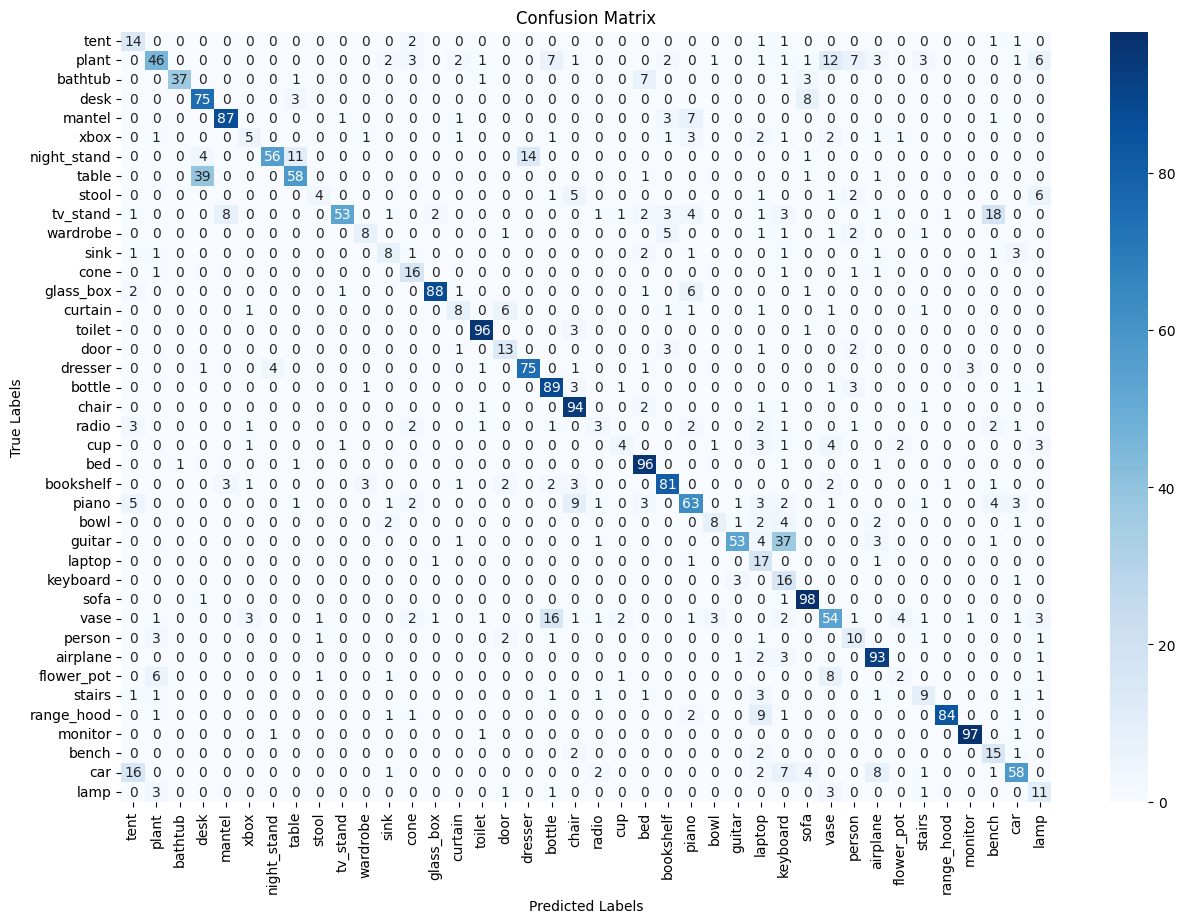

In [26]:
# Print and plot confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

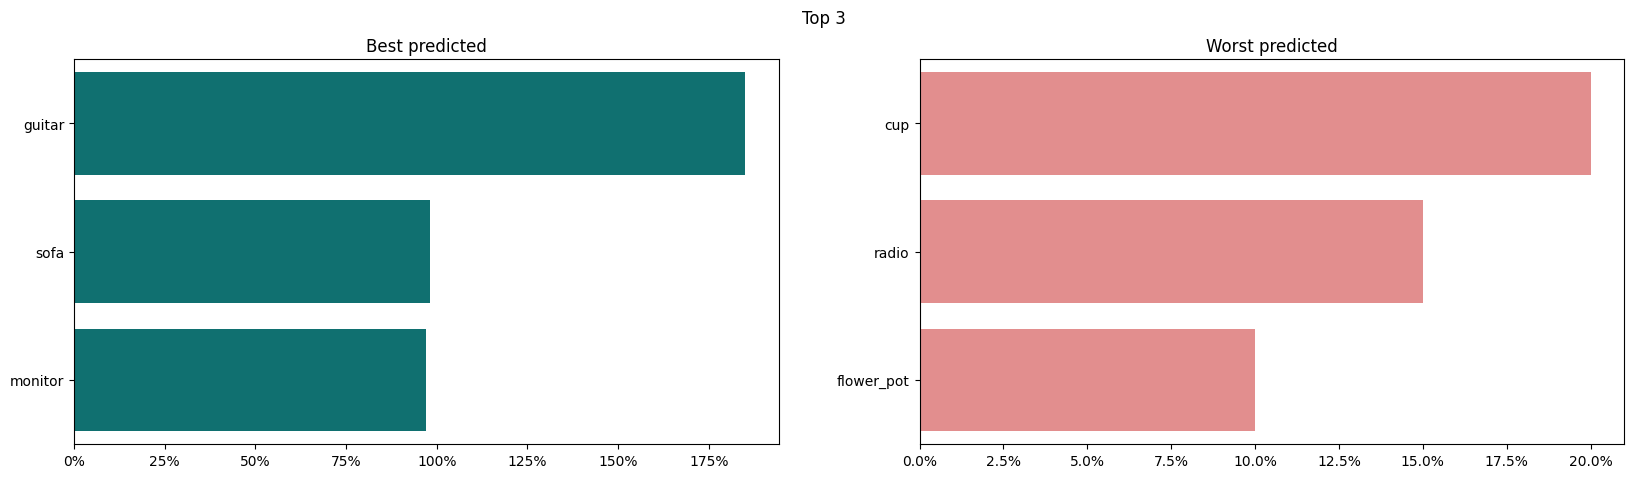

In [27]:
import matplotlib.ticker as mtick

# Calculate the percentage matrix
percent_mat = conf_matrix / np.sum(conf_matrix, axis=1)
percent_sort = np.sort(percent_mat)[:, -1]

# Top 3 best and worst predicted classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

best_3 = np.argpartition(percent_sort, -3)[-3:]
best_3 = np.flip(best_3[np.argsort(percent_sort[best_3])])
best_labels = [class_map[val] for val in best_3]

worst_3 = np.argpartition(percent_sort, 3)[:3]
worst_3 = np.flip(worst_3[np.argsort(percent_sort[worst_3])])
worst_labels = [class_map[val] for val in worst_3]

# Plot the best predicted
plt.subplot(1, 2, 1)
plt.title('Best predicted')
sns.barplot(y=best_labels, x=percent_sort[best_3] * 100, orient='h', color='teal')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter())

# Plot the worst predicted
plt.subplot(1, 2, 2)
plt.title('Worst predicted')
sns.barplot(y=worst_labels, x=percent_sort[worst_3] * 100, orient='h', color='lightcoral')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter())

plt.suptitle('Top 3')
plt.show()


1/1 [==============================] - 1s 734ms/step
The model predicts that Input Class belongs to : airplane


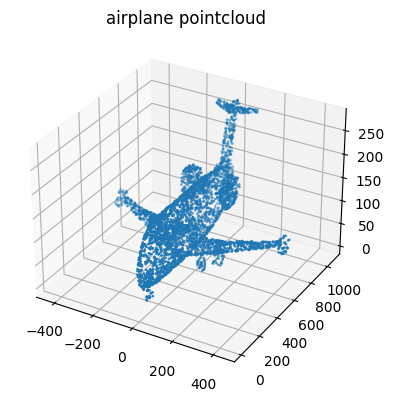

Percentage of predicted class: 99.98%


In [28]:
import trimesh
import numpy as np

# # Load the trained PointNet model
# model = load_model('/kaggle/working/pointnet_weights_v2.hdf5')

# Load a 3D model of an airplane
airplane_mesh = trimesh.load('/content/ModelNet40/airplane/test/airplane_0627.off')

# Sample points from the airplane model
num_points = 1024
airplane_points = airplane_mesh.sample(num_points)

# Expand dimensions to match the model input shape
airplane_points = np.expand_dims(airplane_points, axis=0)

# Make predictions
predictions = model.predict(airplane_points)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to the class name using your class_map dictionary
predicted_class = class_map[predicted_class_index]

# Print the predicted class
print(f'The model predicts that Input Class belongs to : {predicted_class}')

mesh2 = trimesh.load(os.path.join(DATA_DIR, 'airplane/test/airplane_0627.off'))
points2 = mesh2.sample(4096)
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points2[:, 0], points2[:, 1], points2[:, 2], s=1)
ax2.set_title(f'{predicted_class}'+' pointcloud')
#ax.set_axis_off()
plt.show()


# Display the percentage of the predicted class
predicted_percentage = predictions[0, predicted_class_index] * 100
print(f'Percentage of predicted class: {predicted_percentage:.2f}%')

1/1 [==============================] - 0s 21ms/step
The model predicts that Input Class belongs to: table


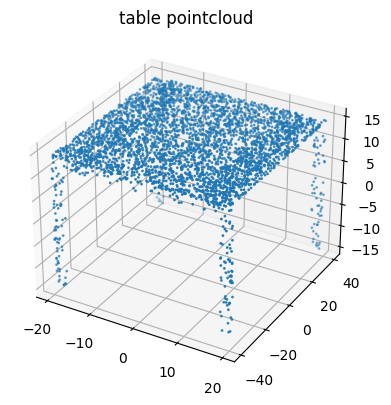

Percentage of predicted class: 99.73%


In [29]:
import trimesh
import numpy as np

# # Load the trained PointNet model
# model = load_model('/kaggle/working/pointnet_weights_v2.hdf5')

# Load a 3D model of an airplane
table_mesh = trimesh.load('/content/ModelNet40/table/test/table_0402.off')

# Sample points from the airplane model
num_points = 1024
table_points = table_mesh.sample(num_points)

# Expand dimensions to match the model input shape
table_points = np.expand_dims(table_points, axis=0)

# Make predictions
predictions = model.predict(table_points)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to the class name using your class_map dictionary
predicted_class = class_map[predicted_class_index]

# Print the predicted class
print(f'The model predicts that Input Class belongs to: {predicted_class}')

mesh2 = trimesh.load(os.path.join(DATA_DIR, 'table/test/table_0402.off'))
points2 = mesh2.sample(4096)
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points2[:, 0], points2[:, 1], points2[:, 2], s=1)
ax2.set_title(f'{predicted_class}'+' pointcloud')
#ax.set_axis_off()
plt.show()


# Display the percentage of the predicted class
predicted_percentage = predictions[0, predicted_class_index] * 100
print(f'Percentage of predicted class: {predicted_percentage:.2f}%')

1/1 [==============================] - 0s 20ms/step
The model predicts that Input Class belongs to: bed


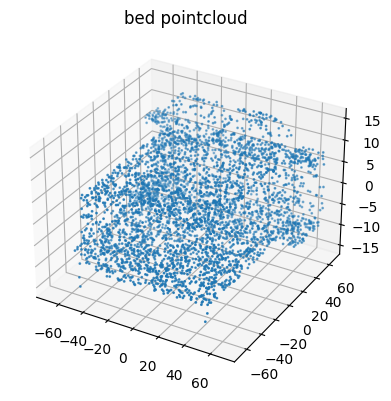

Percentage of predicted class: 99.98%


In [30]:
import trimesh
import numpy as np

# # Load the trained PointNet model
# model = load_model('/kaggle/working/pointnet_weights_v2.hdf5')

# Load a 3D model of an airplane
bed_mesh = trimesh.load('/content/ModelNet40/bed/test/bed_0615.off')

# Sample points from the airplane model
num_points = 1024
bed_points = bed_mesh.sample(num_points)

# Expand dimensions to match the model input shape
bed_points = np.expand_dims(bed_points, axis=0)

# Make predictions
predictions = model.predict(bed_points)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to the class name using your class_map dictionary
predicted_class = class_map[predicted_class_index]

# Print the predicted class
print(f'The model predicts that Input Class belongs to: {predicted_class}')

mesh2 = trimesh.load('/content/ModelNet40/bed/test/bed_0615.off')
points2 = mesh2.sample(4096)
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points2[:, 0], points2[:, 1], points2[:, 2], s=1)
ax2.set_title(f'{predicted_class}'+' pointcloud')
#ax.set_axis_off()
plt.show()


# Display the percentage of the predicted class
predicted_percentage = predictions[0, predicted_class_index] * 100
print(f'Percentage of predicted class: {predicted_percentage:.2f}%')

1/1 [==============================] - 0s 21ms/step
The model predicts that Input Class belongs to: sofa


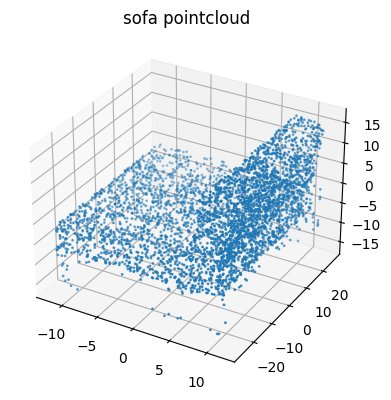

Percentage of predicted class: 100.00%


In [31]:
import trimesh
import numpy as np

# # Load the trained PointNet model
# model = load_model('/kaggle/working/pointnet_weights_v2.hdf5')

# Load a 3D model of an airplane
sofa_mesh = trimesh.load('/content/ModelNet40/sofa/test/sofa_0710.off')

# Sample points from the airplane model
num_points = 1024
sofa_points = sofa_mesh.sample(num_points)

# Expand dimensions to match the model input shape
sofa_points = np.expand_dims(sofa_points, axis=0)

# Make predictions
predictions = model.predict(sofa_points)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to the class name using your class_map dictionary
predicted_class = class_map[predicted_class_index]

# Print the predicted class
print(f'The model predicts that Input Class belongs to: {predicted_class}')

mesh2 = trimesh.load(os.path.join(DATA_DIR, 'sofa/test/sofa_0710.off'))
points2 = mesh2.sample(4096)
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points2[:, 0], points2[:, 1], points2[:, 2], s=1)
ax2.set_title(f'{predicted_class}'+' pointcloud')
#ax.set_axis_off()
plt.show()


# Display the percentage of the predicted class
predicted_percentage = predictions[0, predicted_class_index] * 100
print(f'Percentage of predicted class: {predicted_percentage:.2f}%')

1/1 [==============================] - 0s 21ms/step
The model predicts that Input Class belongs to: piano


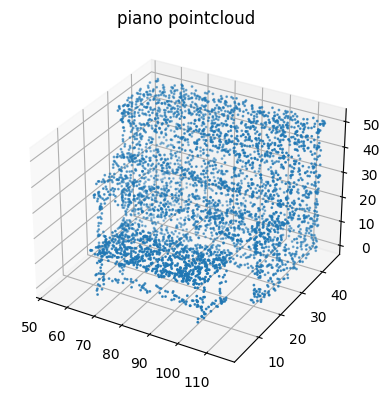

Percentage of predicted class: 82.35%


In [32]:
import trimesh
import numpy as np

# # Load the trained PointNet model
# model = load_model('/kaggle/working/pointnet_weights_v2.hdf5')

# Load a 3D model of an airplane
piano_mesh = trimesh.load('/content/ModelNet40/piano/test/piano_0250.off')

# Sample points from the airplane model
num_points = 1024
piano_points = piano_mesh.sample(num_points)

# Expand dimensions to match the model input shape
piano_points = np.expand_dims(piano_points, axis=0)

# Make predictions
predictions = model.predict(piano_points)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to the class name using your class_map dictionary
predicted_class = class_map[predicted_class_index]

# Print the predicted class
print(f'The model predicts that Input Class belongs to: {predicted_class}')

mesh2 = trimesh.load(os.path.join(DATA_DIR, 'piano/test/piano_0250.off'))
points2 = mesh2.sample(4096)
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points2[:, 0], points2[:, 1], points2[:, 2], s=1)
ax2.set_title(f'{predicted_class}'+' pointcloud')
#ax.set_axis_off()
plt.show()


# Display the percentage of the predicted class
predicted_percentage = predictions[0, predicted_class_index] * 100
print(f'Percentage of predicted class: {predicted_percentage:.2f}%')

1/1 [==============================] - 0s 20ms/step
The model predicts that Input Class belongs to: car


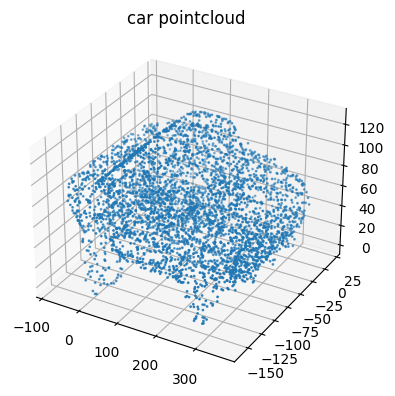

Percentage of predicted class: 96.36%


In [33]:
import trimesh
import numpy as np



# Load a 3D model of an airplane
car_mesh = trimesh.load('/content/ModelNet40/car/train/car_0172.off')

# Sample points from the airplane model
num_points = 1024
car_points = car_mesh.sample(num_points)

# Expand dimensions to match the model input shape
car_points = np.expand_dims(car_points, axis=0)

# Make predictions
predictions = model.predict(car_points)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to the class name using your class_map dictionary
predicted_class = class_map[predicted_class_index]

# Print the predicted class
print(f'The model predicts that Input Class belongs to: {predicted_class}')

mesh2 = trimesh.load('/content/ModelNet40/car/train/car_0172.off')
points2 = mesh2.sample(4096)
fig = plt.figure(figsize=(10,5))
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points2[:, 0], points2[:, 1], points2[:, 2], s=1)
ax2.set_title(f'{predicted_class}'+' pointcloud')
#ax.set_axis_off()
plt.show()


# Display the percentage of the predicted class
predicted_percentage = predictions[0, predicted_class_index] * 100
print(f'Percentage of predicted class: {predicted_percentage:.2f}%')